In [1]:
import pandas as pd
import numpy as np 

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint
import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_json('data.json')
df

,repo,language,readme_contents
0,Priesemann-Group/covid19_inference_forecast,Jupyter Notebook,# Bayesian inference and forecast of COVID-19\...
1,CodeExplainedRepo/COVID-19_TRACKER_HTML_CSS_JA...,JavaScript,# COVID-19_TRACKER_HTML_CSS_JAVASCRIPT\nCOVID-...
2,joanby/covid19,HTML,
3,sambreen27/covid19,JavaScript,A simple ReactJS app that displays latest stat...
4,SJang1/2021-korea-covid-19-remaining-vaccine-m...,Python,# ⚠ This Code is Archived. 더이상 유지보수하지 않습니다.\n2...
...,...,...,...
198,covidcaremap/covid19-healthsystemcapacity,HTML,[![Gitter](https://badges.gitter.im/covid19-he...
199,k-sys/covid-19,Jupyter Notebook,
200,google/exposure-notifications-verification-server,Go,# Archive status announcement\n\nThe Exposure ...
201,github/covid-19-repo-data,None,[![Actions Status](https://github.com/github/c...


In [3]:
df[df['readme_contents'] == '']

,repo,language,readme_contents
2,joanby/covid19,HTML,
89,WorldHealthOrganization/app,Dart,
166,elcronos/COVID-19,JavaScript,
199,k-sys/covid-19,Jupyter Notebook,


In [4]:
df = df[df['readme_contents'] != '']

In [5]:
def basic_clean(string):
    '''
    This function takes in the original text.
    The text is all lowercased, 
    the text is encoded in ascii and any characters that are not ascii are ignored.
    The text is then decoded in utf-8 and any characters that are not ascii are ignored
    Additionally, special characters are all removed.
    A clean article is then returned
    '''
    #lowercase
    string = string.lower()
    
    #normalize
    string = unicodedata.normalize('NFKD', string)\
    .encode('ascii', 'ignore')\
    .decode('utf-8', 'ignore')
    
    #remove special characters and replaces it with blank
    string = re.sub(r"[^a-z0-9'\s]", '', string)
    
    return string

In [6]:
def tokenize(string):
    '''
    This function takes in a string
    and returns the string as individual tokens put back into the string
    '''
    #create the tokenizer
    tokenizer = nltk.tokenize.ToktokTokenizer()

    #use the tokenizer
    string = tokenizer.tokenize(string, return_str = True)

    return string

In [7]:
def stem(string):
    '''
    This function takes in text
    and returns the stem word joined back into the text
    '''
    #create porter stemmer
    ps = nltk.porter.PorterStemmer()
    
    #use the stem, split string using each word
    stems = [ps.stem(word) for word in string.split()]
    
    #join stem word to string
    string = ' '.join(stems)

    return string

In [8]:
def lemmatize(string):
    '''
    This function takes in a string
    and returns the lemmatized word joined back into the string
    '''
    #create the lemmatizer
    wnl = nltk.stem.WordNetLemmatizer()
    
    #look at the article 
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    
    #join lemmatized words into article
    string = ' '.join(lemmas)

    return string

In [9]:
def remove_stopwords(string, extra_words = [], exclude_words = []):
    '''
    This function takes in text, extra words and exclude words
    and returns a list of text with stopword removed
    '''
    #create stopword list
    stopword_list = stopwords.words('english')
    
    #remove excluded words from list
    stopword_list = set(stopword_list) - set(exclude_words)
    
    #add the extra words to the list
    stopword_list = stopword_list.union(set(extra_words))
    
    #split the string into different words
    words = string.split()
    
    #create a list of words that are not in the list
    filtered_words = [word for word in words if word not in stopword_list]
    
    #join the words that are not stopwords (filtered words) back into the string
    string = ' '.join(filtered_words)
    
    return string

In [10]:
def prep_data(df, column, extra_words=[], exclude_words=[]):
    '''
    This function take in a df and the string name for a text column with 
    option to pass lists for extra_words and exclude_words and
    returns a df with the text article title, original text, stemmed text,
    lemmatized text, cleaned, tokenized, & lemmatized text with stopwords removed.
    '''
    
    #chain together clean, tokenize, remove stopwords
    df['clean'] = df[column].apply(basic_clean)\
                            .apply(tokenize)\
                            .apply(remove_stopwords, 
                                   extra_words=extra_words, 
                                   exclude_words=exclude_words)
    
    #chain clean, tokenize, stem, remove stopwords
    df['stemmed'] = df['clean'].apply(stem)
    
    #clean clean, tokenize, lemmatize, remove stopwords
    df['lemmatized'] = df['clean'].apply(lemmatize)
    
    return df[['repo', 'language', 'clean', 'stemmed', 'lemmatized']]

In [11]:
df = prep_data(df, 'readme_contents')
df

,repo,language,clean,stemmed,lemmatized
0,Priesemann-Group/covid19_inference_forecast,Jupyter Notebook,bayesian inference forecast covid19 documentat...,bayesian infer forecast covid19 document statu...,bayesian inference forecast covid19 documentat...
1,CodeExplainedRepo/COVID-19_TRACKER_HTML_CSS_JA...,JavaScript,covid19trackerhtmlcssjavascript covid19 html5 ...,covid19trackerhtmlcssjavascript covid19 html5 ...,covid19trackerhtmlcssjavascript covid19 html5 ...
3,sambreen27/covid19,JavaScript,simple reactjs app displays latest stats covid...,simpl reactj app display latest stat covid19 i...,simple reactjs app display latest stats covid1...
4,SJang1/2021-korea-covid-19-remaining-vaccine-m...,Python,code archived 2021 9 22 koreacovid19remainingv...,code archiv 2021 9 22 koreacovid19remainingvac...,code archived 2021 9 22 koreacovid19remainingv...
5,covid-19-net/covid-19-community,Jupyter Notebook,covid19community project community effort buil...,covid19commun project commun effort build neo4...,covid19community project community effort buil...
...,...,...,...,...,...
197,nihp-public/COVID-19-app-Android-BETA,Kotlin,sonar colocate android license mithttpsimgshie...,sonar coloc android licens mithttpsimgshieldsi...,sonar colocate android license mithttpsimgshie...
198,covidcaremap/covid19-healthsystemcapacity,HTML,gitterhttpsbadgesgitterimcovid19healthsystemca...,gitterhttpsbadgesgitterimcovid19healthsystemca...,gitterhttpsbadgesgitterimcovid19healthsystemca...
200,google/exposure-notifications-verification-server,Go,archive status announcement exposure notificat...,archiv statu announc exposur notif server proj...,archive status announcement exposure notificat...
201,github/covid-19-repo-data,None,actions statushttpsgithubcomgithubcovid19repod...,action statushttpsgithubcomgithubcovid19repoda...,action statushttpsgithubcomgithubcovid19repoda...


In [12]:
df['language'].value_counts()

Python              38
JavaScript          36
Jupyter Notebook    29
HTML                19
R                    9
TypeScript           7
Kotlin               7
Vue                  5
Ruby                 3
TeX                  2
PHP                  2
Go                   2
Dart                 2
Stan                 1
C#                   1
Svelte               1
Java                 1
SCSS                 1
PowerShell           1
TSQL                 1
Objective-C          1
CSS                  1
Name: language, dtype: int64

In [13]:
def seperate_language(df):
    
    desired_languages = ['Python', 'JavaScript', 'Jupyter Notebook', 'HTML', 'R']

    mask = df['language'].isin(desired_languages)

    df['language'] = pd.np.where(mask, df['language'], 'others')

    return df

In [14]:
desired_languages = ['Python', 'JavaScript', 'Jupyter Notebook', 'HTML', 'R']

mask = df['language'].isin(desired_languages)

df['language'] = pd.np.where(mask, df['language'], 'others')

df

,repo,language,clean,stemmed,lemmatized
0,Priesemann-Group/covid19_inference_forecast,Jupyter Notebook,bayesian inference forecast covid19 documentat...,bayesian infer forecast covid19 document statu...,bayesian inference forecast covid19 documentat...
1,CodeExplainedRepo/COVID-19_TRACKER_HTML_CSS_JA...,JavaScript,covid19trackerhtmlcssjavascript covid19 html5 ...,covid19trackerhtmlcssjavascript covid19 html5 ...,covid19trackerhtmlcssjavascript covid19 html5 ...
3,sambreen27/covid19,JavaScript,simple reactjs app displays latest stats covid...,simpl reactj app display latest stat covid19 i...,simple reactjs app display latest stats covid1...
4,SJang1/2021-korea-covid-19-remaining-vaccine-m...,Python,code archived 2021 9 22 koreacovid19remainingv...,code archiv 2021 9 22 koreacovid19remainingvac...,code archived 2021 9 22 koreacovid19remainingv...
5,covid-19-net/covid-19-community,Jupyter Notebook,covid19community project community effort buil...,covid19commun project commun effort build neo4...,covid19community project community effort buil...
...,...,...,...,...,...
197,nihp-public/COVID-19-app-Android-BETA,others,sonar colocate android license mithttpsimgshie...,sonar coloc android licens mithttpsimgshieldsi...,sonar colocate android license mithttpsimgshie...
198,covidcaremap/covid19-healthsystemcapacity,HTML,gitterhttpsbadgesgitterimcovid19healthsystemca...,gitterhttpsbadgesgitterimcovid19healthsystemca...,gitterhttpsbadgesgitterimcovid19healthsystemca...
200,google/exposure-notifications-verification-server,others,archive status announcement exposure notificat...,archiv statu announc exposur notif server proj...,archive status announcement exposure notificat...
201,github/covid-19-repo-data,others,actions statushttpsgithubcomgithubcovid19repod...,action statushttpsgithubcomgithubcovid19repoda...,action statushttpsgithubcomgithubcovid19repoda...


In [15]:
df['language'].value_counts()

others              68
Python              38
JavaScript          36
Jupyter Notebook    29
HTML                19
R                    9
Name: language, dtype: int64

In [16]:
len(df['language'])

199

In [17]:
def train_val_test(df,col):
    seed = 42
    
    ''' This function is to split our data into our train, validate, and test subsets. We put in a dataframe
    and our target variable to then return the subsets of train, validate and test.'''
    
    train, test = train_test_split(df, train_size = 0.7, random_state = seed, stratify = df[col])
    
    validate, test = train_test_split(test, test_size = 0.5, random_state = seed, stratify = test[col])
    
    return train, validate, test

In [18]:
train, validate, test = train_val_test(df, 'language')

train.shape, validate.shape, test.shape

((139, 5), (30, 5), (30, 5))

In [19]:
train

,repo,language,clean,stemmed,lemmatized
173,imdevskp/covid-19-india-data,Jupyter Notebook,covid19indiadata repository contains data code...,covid19indiadata repositori contain data code ...,covid19indiadata repository contains data code...
185,kaz-ogiwara/covid19,HTML,coronavirus disease covid19 situation report j...,coronaviru diseas covid19 situat report japan ...,coronavirus disease covid19 situation report j...
39,lispc/covid19-citymap-china,JavaScript,api github pages httpslispcgithubiocovid19city...,api github page httpslispcgithubiocovid19citym...,api github page httpslispcgithubiocovid19citym...
7,lisphilar/covid19-sir,Python,img srchttpsrawgithubusercontentcomlisphilarco...,img srchttpsrawgithubusercontentcomlisphilarco...,img srchttpsrawgithubusercontentcomlisphilarco...
19,CodeForPhilly/chime,Python,chime covid19 hospital impact model epidemics ...,chime covid19 hospit impact model epidem pennc...,chime covid19 hospital impact model epidemic p...
...,...,...,...,...,...
101,cloudboxacademy/covid19,others,covid19 resources udemy course azure data fact...,covid19 resourc udemi cours azur data factori ...,covid19 resource udemy course azure data facto...
158,ThisIsIsaac/Data-Science-for-COVID-19,others,bannerhttpsgithubcomthisisisaacdatascienceforc...,bannerhttpsgithubcomthisisisaacdatascienceforc...,bannerhttpsgithubcomthisisisaacdatascienceforc...
33,jihoo-kim/Data-Science-for-COVID-19,Jupyter Notebook,githublogohttpsuserimagesgithubusercontentcom5...,githublogohttpsuserimagesgithubusercontentcom5...,githublogohttpsuserimagesgithubusercontentcom5...
85,peixebabel/COVID-19,HTML,covid19 dados e plots sobre informacoes corona...,covid19 dado e plot sobr informaco corona viru...,covid19 dado e plot sobre informacoes corona v...


In [20]:
train_java = train[train['language'] == 'JavaScript']
train_juypter =train[train['language'] == 'Jupyter Notebook']

(-0.5, 399.5, 199.5, -0.5)

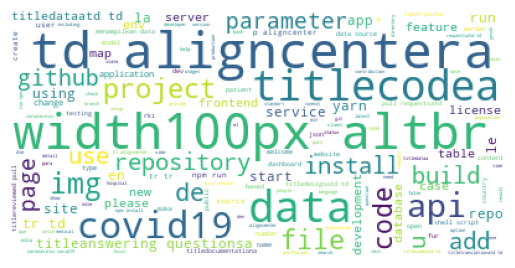

In [21]:
repo_java_lem = ' '.join(train_java['lemmatized'])

blog_img = WordCloud(background_color='white').generate(repo_java_lem)
plt.imshow(blog_img)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

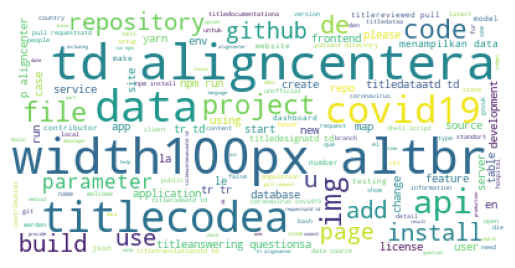

In [22]:
repo_jupyter_lem = ' '.join(train_java['lemmatized'])

blog_img = WordCloud(background_color='white').generate(repo_jupyter_lem)
plt.imshow(blog_img)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

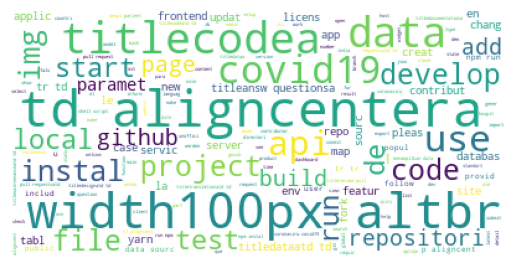

In [23]:
repo_jupyter_stem = ' '.join(train_java['stemmed'])

blog_img = WordCloud(background_color='white').generate(repo_jupyter_stem)
plt.imshow(blog_img)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

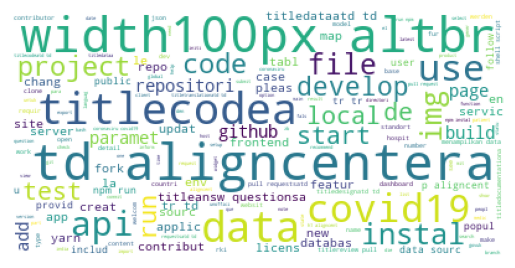

In [24]:
repo_java_stem = ' '.join(train_java['stemmed'])

blog_img = WordCloud(background_color='white').generate(repo_java_stem)
plt.imshow(blog_img)
plt.axis('off')

In [25]:
labels = pd.concat([train.language.value_counts(),
                    train.language.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels


,n,percent
others,48,0.345324
Python,27,0.194245
JavaScript,25,0.179856
Jupyter Notebook,20,0.143885
HTML,13,0.093525
R,6,0.043165


In [26]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(train, "language")


,n,percent
others,48,0.345324
Python,27,0.194245
JavaScript,25,0.179856
Jupyter Notebook,20,0.143885
HTML,13,0.093525
R,6,0.043165


In [27]:
tokenize = nltk.tokenize.ToktokTokenizer()
#java_words = tokenize.tokenize(repo_java_lem)
#java_words

In [28]:
#java_freq_words = pd.Series(java_words).value_counts()
#java_freq_words

In [29]:
jupyter_words = tokenize.tokenize(repo_jupyter_lem)
jupyter_freq_words = pd.Series(jupyter_words).value_counts()
jupyter_freq_words

td                                                                   120
width100px                                                           107
data                                                                 104
aligncentera                                                         102
altbr                                                                102
                                                                    ... 
subbanson                                                              1
chongbsubabr                                                           1
hrefhttpsgithubcomneherlabcovid19scenarioscommitsauthorchonganson      1
hrefdesignchonganson                                                   1
detailsappointmentdetailspng                                           1
Length: 3412, dtype: int64

## Modeling

In [30]:
train

,repo,language,clean,stemmed,lemmatized
173,imdevskp/covid-19-india-data,Jupyter Notebook,covid19indiadata repository contains data code...,covid19indiadata repositori contain data code ...,covid19indiadata repository contains data code...
185,kaz-ogiwara/covid19,HTML,coronavirus disease covid19 situation report j...,coronaviru diseas covid19 situat report japan ...,coronavirus disease covid19 situation report j...
39,lispc/covid19-citymap-china,JavaScript,api github pages httpslispcgithubiocovid19city...,api github page httpslispcgithubiocovid19citym...,api github page httpslispcgithubiocovid19citym...
7,lisphilar/covid19-sir,Python,img srchttpsrawgithubusercontentcomlisphilarco...,img srchttpsrawgithubusercontentcomlisphilarco...,img srchttpsrawgithubusercontentcomlisphilarco...
19,CodeForPhilly/chime,Python,chime covid19 hospital impact model epidemics ...,chime covid19 hospit impact model epidem pennc...,chime covid19 hospital impact model epidemic p...
...,...,...,...,...,...
101,cloudboxacademy/covid19,others,covid19 resources udemy course azure data fact...,covid19 resourc udemi cours azur data factori ...,covid19 resource udemy course azure data facto...
158,ThisIsIsaac/Data-Science-for-COVID-19,others,bannerhttpsgithubcomthisisisaacdatascienceforc...,bannerhttpsgithubcomthisisisaacdatascienceforc...,bannerhttpsgithubcomthisisisaacdatascienceforc...
33,jihoo-kim/Data-Science-for-COVID-19,Jupyter Notebook,githublogohttpsuserimagesgithubusercontentcom5...,githublogohttpsuserimagesgithubusercontentcom5...,githublogohttpsuserimagesgithubusercontentcom5...
85,peixebabel/COVID-19,HTML,covid19 dados e plots sobre informacoes corona...,covid19 dado e plot sobr informaco corona viru...,covid19 dado e plot sobre informacoes corona v...


In [31]:
train['stemmed'][0]

"bayesian infer forecast covid19 document statushttpsreadthedocsorgprojectscovid19inferenceforecastbadgeversionlatesthttpscovid19inferenceforecastreadthedocsioenlatestbadgelatest licens gpl v3httpsimgshieldsiobadgelicensegplv3bluesvghttpswwwgnuorglicensesgpl30 doihttpszenodoorgbadgedoi105281zenodo3823382svghttpsdoiorg105281zenodo3823382 current code develop take place new repositoryhttpsgithubcompriesemanngroupcovid19infer research articl avail arxivhttpsarxivorgabs200401105 press sciencehttpssciencesciencemagorgcontentearly20200514scienceabb9789 addit publish technic note answer common question technic notestechnicalnotesdehningetal2020pdf keep updat figur provid origin code research articl get start see sirgermany3scenarioswithsineweekendipynbhttpsgithubcompriesemanngroupcovid19inferenceforecastblobmasterscriptspaper200429sirgermany3scenarioswithsineweekendipynb gener fig 3 research articl scriptspaper200429httpsgithubcompriesemanngroupcovid19inferenceforecastblobmasterscriptspaper20

In [32]:
# Create a CountVectorizer
count_vectorizer = CountVectorizer(stop_words="english")

# Fit and transform the "clean" column using the CountVectorizer
clean_count = count_vectorizer.fit_transform(train["clean"])

# Create a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english")

# Fit and transform the "clean" column using the TfidfVectorizer
clean_tfidf = tfidf_vectorizer.fit_transform(train["clean"])

In [33]:
# Create a DecisionTreeClassifier using the CountVectorizer
dtc_count = DecisionTreeClassifier()
dtc_count.fit(clean_count, train["language"])

DecisionTreeClassifier()

In [34]:
# Predict using the CountVectorizer model
count_pred = dtc_count.predict(clean_count)
print("Accuracy with CountVectorizer:", accuracy_score(train["language"], count_pred))

Accuracy with CountVectorizer: 1.0


In [35]:
# Create a DecisionTreeClassifier using the TfidfVectorizer
dtc_tfidf = DecisionTreeClassifier()
dtc_tfidf.fit(clean_tfidf, train["language"])

DecisionTreeClassifier()

In [36]:
# Predict using the TfidfVectorizer model
tfidf_pred = dtc_tfidf.predict(clean_tfidf)
print("Accuracy with TfidfVectorizer:", accuracy_score(train["language"], tfidf_pred))

Accuracy with TfidfVectorizer: 1.0


In [37]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define the vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer to the training data and transform the data
X_train_vec = vectorizer.fit_transform(train['lemmatized'])

# Transform the test data using the same vectorizer
X_test_vec = vectorizer.transform(test['lemmatized'])

# Define the model
clf = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
clf.fit(X_train_vec, train['language'])

# Predict the language labels for the test data
y_pred = clf.predict(X_test_vec)

# Calculate evaluation metrics
accuracy = accuracy_score(test['language'], y_pred)
precision = precision_score(test['language'], y_pred, average='weighted')
recall = recall_score(test['language'], y_pred, average='weighted')
f1 = f1_score(test['language'], y_pred, average='weighted')
cm = confusion_matrix(test['language'], y_pred)

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:\n', cm)


Accuracy: 0.43333333333333335
Precision: 0.3427350427350427
Recall: 0.43333333333333335
F1 Score: 0.3805797101449276
Confusion Matrix:
 [[0 0 0 1 0 2]
 [1 4 0 0 0 1]
 [0 1 0 1 0 2]
 [0 2 0 3 0 1]
 [0 0 0 0 0 1]
 [0 2 1 1 0 6]]


In [38]:
'''
# Split the data into train, validation, and test sets
train = df[:136]
valid = df[136:166]
test = df[166:]

# Fit a TF-IDF vectorizer on the train data and transform the data
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(train['lemmatized'])

# Transform the validation data and test data using the same vectorizer
X_valid_vec = vectorizer.transform(valid['lemmatized'])
X_test_vec = vectorizer.transform(test['lemmatized'])

# Fit a decision tree classifier on the train data and predict the validation data
dtc = DecisionTreeClassifier()
dtc.fit(X_train_vec, train['language'])
y_valid_pred = dtc.predict(X_valid_vec)

# Evaluate the model on the validation data
print("Validation set evaluation:")
print("Accuracy:", accuracy_score(valid['language'], y_valid_pred))
print("Precision:", precision_score(valid['language'], y_valid_pred, average='macro'))
print("Recall:", recall_score(valid['language'], y_valid_pred, average='macro'))
print("F1 Score:", f1_score(valid['language'], y_valid_pred, average='macro'))
print("Confusion matrix:\n", confusion_matrix(valid['language'], y_valid_pred))

# Fit a decision tree classifier on the train data and predict the test data
dtc.fit(X_train_vec, train['language'])
y_test_pred = dtc.predict(X_test_vec)

# Evaluate the model on the test data
print("\nTest set evaluation:")
print("Accuracy:", accuracy_score(test['language'], y_test_pred))
print("Precision:", precision_score(test['language'], y_test_pred, average='macro'))
print("Recall:", recall_score(test['language'], y_test_pred, average='macro'))
print("F1 Score:", f1_score(test['language'], y_test_pred, average='macro'))
print("Confusion matrix:\n", confusion_matrix(test['language'], y_test_pred))

# Generate predicted labels for the test data
y_test_pred = dtc.predict(X_test_vec)
#y_test_pred = y_test_pred.tolist()

# Print the actual and predicted language for each row in the test data
for i, row in test.iterrows():
    print("Actual language: {}, Predicted language: {}".format(row['language'], y_test_pred[i]))
'''

'\n# Split the data into train, validation, and test sets\ntrain = df[:136]\nvalid = df[136:166]\ntest = df[166:]\n\n# Fit a TF-IDF vectorizer on the train data and transform the data\nvectorizer = TfidfVectorizer()\nX_train_vec = vectorizer.fit_transform(train[\'lemmatized\'])\n\n# Transform the validation data and test data using the same vectorizer\nX_valid_vec = vectorizer.transform(valid[\'lemmatized\'])\nX_test_vec = vectorizer.transform(test[\'lemmatized\'])\n\n# Fit a decision tree classifier on the train data and predict the validation data\ndtc = DecisionTreeClassifier()\ndtc.fit(X_train_vec, train[\'language\'])\ny_valid_pred = dtc.predict(X_valid_vec)\n\n# Evaluate the model on the validation data\nprint("Validation set evaluation:")\nprint("Accuracy:", accuracy_score(valid[\'language\'], y_valid_pred))\nprint("Precision:", precision_score(valid[\'language\'], y_valid_pred, average=\'macro\'))\nprint("Recall:", recall_score(valid[\'language\'], y_valid_pred, average=\'macro

In [39]:
'''for index, row in test.iterrows():
    print("Actual language: {}, Predicted language: {}".format(row['language'], y_test_pred[index]))'''

'for index, row in test.iterrows():\n    print("Actual language: {}, Predicted language: {}".format(row[\'language\'], y_test_pred[index]))'

In [40]:
cv = CountVectorizer()
X = cv.fit_transform(train.lemmatized)
y = train.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=13)

tree = DecisionTreeClassifier(max_depth=2, random_state=123)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score: 35.71%


In [41]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(train.lemmatized)
y = train.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=13)

tree = DecisionTreeClassifier(max_depth=17, random_state=13)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score: 14.29%


In [42]:
cv = CountVectorizer(ngram_range=(2, 2))
X = cv.fit_transform(train.lemmatized)
y = train.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=13)

tree = DecisionTreeClassifier(max_depth=26, random_state=13)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score: 35.71%


In [43]:
cv = CountVectorizer(ngram_range=(3, 3))
X = cv.fit_transform(train.lemmatized)
y = train.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=13)

tree = DecisionTreeClassifier(max_depth=25, random_state=13)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score: 35.71%


In [44]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1311)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=113)

In [45]:
train.shape, validate.shape, test.shape

((139, 5), (30, 5), (30, 5))

In [46]:
baseline=(y_train=='others').mean()
print('The baseline accuracy is ',baseline)

The baseline accuracy is  0.3132530120481928


In [47]:
df.columns

Index(['repo', 'language', 'clean', 'stemmed', 'lemmatized'], dtype='object')

In [48]:
#function to split data for Count models including bi/tri-grams models
def split_cv_models(df, stem_or_lem, ngram_range = (1,1)): 
    
    random_seed = 42
    
    X = df[['stemmed', 'lemmatized']] 
    y = df.language
          
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = .3, random_state = random_seed)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = .5, random_state = random_seed)
    
    cv = CountVectorizer(ngram_range = ngram_range)
    X_train = cv.fit_transform(X_train[stem_or_lem])
    X_val = cv.transform(X_val[stem_or_lem])
    X_test = cv.transform(X_test[stem_or_lem])
    y_train = y_train 

    return X_train, y_train, X_val, y_val, X_test, y_test

In [49]:
X_train, y_train, X_val, y_val, X_test, y_test = split_cv_models(df, 'lemmatized')

In [50]:
def shape_split_data():
    
    X_train, y_train, X_val, y_val, X_test, y_test = split_cv_models(df,'lemmatized')
    print(X_train.shape, X_val.shape, X_test.shape) 
    print(y_train.shape[0], y_val.shape[0], y_test.shape[0])

In [51]:
shape_split_data()

(139, 19932) (30, 19932) (30, 19932)
139 30 30


In [52]:
X_train, y_train, X_val, y_val, X_test, y_test = split_cv_models(df,'lemmatized')
print(X_train.shape, X_val.shape, X_test.shape) 
print(y_train.shape[0], y_val.shape[0], y_test.shape[0])

(139, 19932) (30, 19932) (30, 19932)
139 30 30


In [53]:
def baseline_model(df, stem_or_lem, ngram_range = (1,1)):
    
    X_train, y_train, X_val, y_val, X_test, y_test = split_cv_models(df, stem_or_lem, ngram_range = (1,1))
    
    baseline = (y_train =='others').mean()
    return baseline 
#print(f'The baseline accuracy is {baseline:.2%}')

In [54]:
baseline_model(train, 'lemmatized')

0.35051546391752575

In [55]:
def cv_model(df, stem_or_lem, ngram_range = (1,1)):
    
    X_train, y_train, X_val, y_val, X_test, y_test = split_cv_models(df, stem_or_lem, ngram_range = (1,1))
    
    # Count Vectorizer
    bwtree = DecisionTreeClassifier(max_depth=12, random_state=123)
    bwtree.fit(X_train, y_train)


    print(f'Accuracy Score: {bwtree.score(X_val, y_val) * 100:.2f}%')
    

In [56]:
cv_model(df, 'lemmatized')

Accuracy Score: 26.67%


In [57]:
cv = CountVectorizer()
X = cv.fit_transform(train.lemmatized)
y = train.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 1311)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state = 1311)

bwtree = DecisionTreeClassifier(max_depth=12, random_state=123)
bwtree.fit(X_train, y_train)

print(f'Accuracy Score: {bwtree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score: 28.57%


In [58]:
def split_tf_idf_data(df, stem_or_lem): 
    
    random_seed = 42
    
    X = df[['stemmed', 'lemmatized']] 
    y = df.language
          
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = .3, random_state = random_seed)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = .5, random_state = random_seed)
    
    tfidf = TfidfVectorizer()
    X_train = tfidf.fit_transform(X_train[stem_or_lem])
    X_val = tfidf.transform(X_val[stem_or_lem])
    X_test = tfidf.transform(X_test[stem_or_lem])

    return X_train, y_train, X_val, y_val, X_test, y_test

In [59]:
def tf_idf_model(df, stem_or_lem):
    
    X_train, y_train, X_val, y_val, X_test, y_test = split_tf_idf_data(df, stem_or_lem)
    
    # Count Vectorizer
    tftree = DecisionTreeClassifier(max_depth=17, random_state=13)
    tftree.fit(X_train, y_train)

    print(f'Accuracy Score: {tftree.score(X_val, y_val) * 100:.2f}%')

In [60]:
tf_idf_model(df, 'lemmatized')

Accuracy Score: 26.67%


In [61]:
# TF-IDF approach
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(train.lemmatized)
y = train.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1311)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=113)

tftree = DecisionTreeClassifier(max_depth=17, random_state=13)
tftree.fit(X_train, y_train)

print(f'Accuracy Score: {tftree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score: 28.57%


In [62]:
def bigram_model(df, stem_or_lem, ngram_range = (1,1)):
    
    X2_train, y2_train, X2_val, y2_val, X2_test, y2_test = split_cv_models(df, stem_or_lem, ngram_range = ngram_range)
    
    # Bigram Count Vectorizer
    bitree = DecisionTreeClassifier(max_depth=16, random_state=13)
    bitree.fit(X2_train, y2_train)


    print(f'Accuracy Score: {bitree.score(X2_val, y2_val) * 100:.2f}%')    

In [63]:
bigram_model(df, 'lemmatized', ngram_range=(2,2))

Accuracy Score: 26.67%


In [64]:
# Bigram approach
cv = CountVectorizer(ngram_range=(2, 2))
X = cv.fit_transform(train.lemmatized)
y = train.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1311)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=113)

bitree = DecisionTreeClassifier(max_depth=16, random_state=13)
bitree.fit(X_train, y_train)

print(f'Accuracy Score: {bitree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score: 32.14%


In [65]:
def trigram_model(df, stem_or_lem, ngram_range = (1,1)):
    
    X3_train, y3_train, X3_val, y3_val, X3_test, y3_test = split_cv_models(df, stem_or_lem, ngram_range = ngram_range)
    
    # trigram Count Vectorizer
    titree = DecisionTreeClassifier(max_depth=12, random_state=123)
    titree.fit(X3_train, y3_train)


    print(f'Accuracy Score: {titree.score(X3_val, y3_val) * 100:.2f}%')

In [66]:
trigram_model(df, 'lemmatized', ngram_range = (3,3))

Accuracy Score: 36.67%


In [67]:
# Tri-gram
cv = CountVectorizer(ngram_range=(3, 3))
X = cv.fit_transform(train.lemmatized)
y = train.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1311)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=113)

titree = DecisionTreeClassifier(max_depth=12, random_state=123)
titree.fit(X_train, y_train)

print(f'Accuracy Score: {titree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score: 21.43%


In [68]:
X_train, y_train, X_val, y_val, X_test, y_test = split_tf_idf_data(df, 'lemmatized')
 
for i in range(1,20):    
    tftree = DecisionTreeClassifier(max_depth = i, random_state=13)
    tftree.fit(X_train, y_train)

    print(f'Accuracy Score: {tftree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score: 33.33%
Accuracy Score: 33.33%
Accuracy Score: 30.00%
Accuracy Score: 26.67%
Accuracy Score: 26.67%
Accuracy Score: 30.00%
Accuracy Score: 26.67%
Accuracy Score: 30.00%
Accuracy Score: 26.67%
Accuracy Score: 30.00%
Accuracy Score: 26.67%
Accuracy Score: 26.67%
Accuracy Score: 23.33%
Accuracy Score: 26.67%
Accuracy Score: 23.33%
Accuracy Score: 26.67%
Accuracy Score: 26.67%
Accuracy Score: 26.67%
Accuracy Score: 26.67%


In [69]:
#Tree models
metrics = []

for i in range(2,20):
    
    tftree = DecisionTreeClassifier(max_depth = i, random_state=13)
    tftree.fit(X_train, y_train)
    
    in_sample_accuracy = tftree.score(X_train, y_train)
    
    out_of_sample_accuracy = tftree.score(X_val, y_val)

    output = {
            'max_depth' : i,
            'train_accuracy': in_sample_accuracy,
            'validate_accuracy': out_of_sample_accuracy
             }
    
    metrics.append(output)
    
dff = pd.DataFrame(metrics)
dff["difference"] = dff.train_accuracy - dff.validate_accuracy
dff.sort_values('difference')

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.482014,0.333333,0.148681
1,3,0.525180,0.300000,0.225180
2,4,0.568345,0.266667,0.301679
4,6,0.654676,0.300000,0.354676
3,5,0.625899,0.266667,0.359233
5,7,0.726619,0.266667,0.459952
6,8,0.769784,0.300000,0.469784
7,9,0.827338,0.266667,0.560671
8,10,0.863309,0.300000,0.563309
9,11,0.884892,0.266667,0.618225


In [70]:
#KNNs
models_accuracy = []

for i in range(1,21):

    knn = KNeighborsClassifier(n_neighbors = i)
    
    knn = knn.fit(X_train, y_train)
    
    accuracy = knn.score(X_train, y_train)
    accuracy_val = knn.score(X_val, y_val)
    difference = accuracy - accuracy_val
    models_accuracy.append([i, accuracy, accuracy_val, difference])
    
knn_metrics = pd.DataFrame(models_accuracy, columns =['neighbors', 'train_accuracy', 'validate_accuracy','difference'])
knn_metrics.sort_values(by=['difference'])#.loc[7]

,neighbors,train_accuracy,validate_accuracy,difference
19,20,0.417266,0.500000,-0.082734
16,17,0.460432,0.500000,-0.039568
15,16,0.474820,0.500000,-0.025180
11,12,0.474820,0.500000,-0.025180
17,18,0.446043,0.466667,-0.020624
18,19,0.446043,0.466667,-0.020624
10,11,0.503597,0.500000,0.003597
6,7,0.525180,0.500000,0.025180
12,13,0.467626,0.433333,0.034293
13,14,0.503597,0.466667,0.036930


In [71]:
#random forests
metrics = []
max_depth = 11

for i in range(1, max_depth):
   
    depth = max_depth - i
    n_samples = i
    rf = RandomForestClassifier(max_depth = depth, min_samples_leaf = n_samples,
                                random_state = 22, n_estimators = 200)

    rf = rf.fit(X_train, y_train)
    
    in_sample_accuracy = rf.score(X_train, y_train)
    
    out_of_sample_accuracy = rf.score(X_val, y_val)

    output = {
            'min_samples_per_leaf': n_samples,
            'max_depth': depth,
            'train_accuracy': in_sample_accuracy,
            'validate_accuracy': out_of_sample_accuracy
            }
    
    metrics.append(output)
    
rf = pd.DataFrame(metrics)
rf["difference"] = rf.train_accuracy - rf.validate_accuracy
rf.sort_values(by=['difference'])

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
8,9,2,0.345324,0.333333,0.011990
9,10,1,0.345324,0.333333,0.011990
7,8,3,0.352518,0.333333,0.019185
6,7,4,0.359712,0.333333,0.026379
5,6,5,0.395683,0.333333,0.062350
4,5,6,0.431655,0.333333,0.098321
3,4,7,0.503597,0.333333,0.170264
2,3,8,0.676259,0.333333,0.342926
1,2,9,0.741007,0.333333,0.407674
0,1,10,0.834532,0.333333,0.501199


In [72]:
def models(df, stem_or_lem):
    
    random_state = 42
    
    X_train, y_train, X_val, y_val, X_test, y_test = split_tf_idf_data(df, stem_or_lem)
    
    #Tree model
    tftree = DecisionTreeClassifier(max_depth = 2, random_state=random_state)
    tftree.fit(X_train, y_train)

    in_sample_accuracy = tftree.score(X_train, y_train)
    out_of_sample_accuracy = tftree.score(X_val, y_val)

    # KNN model
    knn = KNeighborsClassifier(n_neighbors = 7)
    knn = knn.fit(X_train, y_train)

    accuracy_train = knn.score(X_train, y_train)
    accuracy_val = knn.score(X_val, y_val)
    
    #Logistic Regression
    logit = LogisticRegression(random_state = random_state)
    logit.fit(X_train, y_train)

    acc_train = logit.score(X_train, y_train)
    acc_val = logit.score(X_val, y_val)
    
    #Random Forest
    
    rf = RandomForestClassifier(max_depth = 2, min_samples_leaf = 9,
                                random_state = random_state, n_estimators = 200)
    rf = rf.fit(X_train, y_train)
    
    in_accuracy = rf.score(X_train, y_train)
    out_accuracy = rf.score(X_val, y_val)
    
    
    #Baseline
    baseline_model(df, stem_or_lem)
    baseline = (y_train =='others').mean()
    
    dff = pd.DataFrame({'model': ['Decision Tree', 'KNN', 'Logistic Regression', 'Random Forest', 'Baseline'],
                      'train_accuracy': [in_sample_accuracy, accuracy_train, acc_train, in_accuracy ,baseline],
                      'validate_accuracy': [out_of_sample_accuracy, accuracy_val, acc_val, out_accuracy, baseline]})

    return dff.sort_values('validate_accuracy', ascending = False)


In [73]:
models(df, 'lemmatized')

,model,train_accuracy,validate_accuracy
1,KNN,0.525180,0.500000
2,Logistic Regression,0.820144,0.366667
4,Baseline,0.345324,0.345324
0,Decision Tree,0.482014,0.333333
3,Random Forest,0.345324,0.333333


In [74]:
def best_model(df, stem_or_lem):
    
    random_state = 42
    
    X_train, y_train, X_val, y_val, X_test, y_test = split_tf_idf_data(df, stem_or_lem)
    
    knn = KNeighborsClassifier(n_neighbors = 7)
    knn = knn.fit(X_train, y_train)

    accuracy_train = knn.score(X_train, y_train)
    accuracy_val = knn.score(X_val, y_val)
    accuracy_test = knn.score(X_test, y_test)
    
    df = pd.DataFrame({'model': ['KNN','baseline'],
                      'train_accuracy': [accuracy_train, baseline],
                      'validate_accuracy': [accuracy_val, baseline],
                      'test_accuracy': [accuracy_test, baseline]})

    
    return df

In [75]:
best_model(df, 'lemmatized')

,model,train_accuracy,validate_accuracy,test_accuracy
0,KNN,0.525180,0.500000,0.533333
1,baseline,0.313253,0.313253,0.313253
